In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [ ]:
df = pd.read_excel('/content/health_data_clean.xlsx')
df.head(5)

,Year,Month,District,Live_Births,ANC_Registrations,Early_ANC_Registrations,ANC_4_Checkups,Institutional_Deliveries,Home_Deliveries,Urban_Institutional_Deliveries,...,Institutional_Delivery_Rate,Immunization_Coverage,MMR,IMR,Urban_Delivery_Rate,Rural_Delivery_Rate,Rural_Urban_Gap,MMR_Score,IMR_Score,Composite_Health_Index
0,2024,Sep,Puri,359.0,712.0,507.0,156.0,257.0,102.0,131,...,71.587744,104.735376,139.275766,11.142061,74.431818,68.852459,5.579359,85.190344,74.558090,67.772364
1,2023,Mar,Koraput,452.0,458.0,339.0,214.0,366.0,106.0,208,...,77.542373,152.433628,331.858407,15.486726,87.029289,74.178404,12.850885,64.712389,63.092308,79.685335
2,2023,Nov,Sambalpur,496.0,550.0,328.0,343.0,453.0,43.0,200,...,91.330645,75.806452,403.225806,12.096774,94.786730,88.771930,6.014800,57.123656,72.038556,71.272613
3,2023,Nov,Puri,770.0,874.0,604.0,533.0,578.0,192.0,390,...,75.064935,94.415584,0.000000,14.285714,82.802548,62.876254,19.926294,100.000000,66.261836,74.871893
4,2024,Feb,Balasore,708.0,833.0,379.0,357.0,564.0,128.0,394,...,81.502890,95.338983,141.242938,12.711864,84.368308,70.539419,13.828889,84.981168,70.415303,66.277284


In [ ]:
# Target
TARGET = "IMR"

In [ ]:
# Features (dropping target & leakage columns)
features = [
"District", "Year", "Month",
"Live_Births", "ANC_Registrations", "Early_ANC_Registrations", "ANC_4_Checkups",
"Institutional_Deliveries", "Home_Deliveries",
"Urban_Institutional_Deliveries", "Rural_Institutional_Deliveries",
"Children_Eligible_0_11m", "Children_Immunized",
"ANC_Care_Index", "ANC_Completion_Rate", "Immunization_Coverage",
"MMR", "Rural_Urban_Gap", "Composite_Health_Index"
]

In [ ]:
X = df[features]
y = df[TARGET]

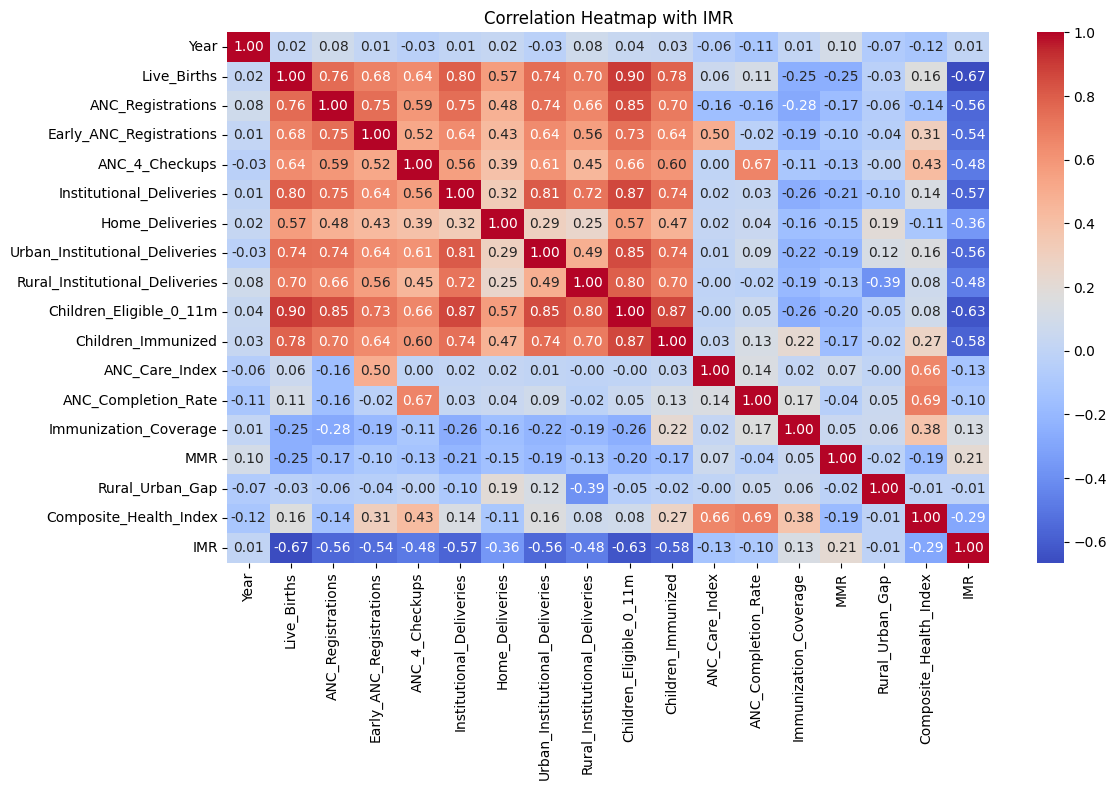

In [ ]:
plt.figure(figsize=(12,8))
num_cols = [col for col in X.columns if X[col].dtype != 'object']
corr = df[num_cols + [TARGET]].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap with IMR")
plt.tight_layout()
plt.show()

In [ ]:
cat_cols = ["District", "Month"]
num_cols = [col for col in X.columns if col not in cat_cols]

In [ ]:
preprocessor = ColumnTransformer(
    transformers = [
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols)
    ]
)

NameError: name 'cat_cols' is not defined

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
models = {
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

results = {}

In [19]:
for name, model in models.items():
    pipe = Pipeline(steps=[("preprocess", preprocessor), ("model", model)])

    # Cross-validation for robustness
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="r2")

    # Train on full training set
    pipe.fit(X_train, y_train)

    # Evaluate on test set
    y_pred = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        "CV Mean R2": np.mean(cv_scores),
        "Test RMSE": rmse,
        "Test R2": r2,
        "Model": pipe
    }


In [21]:
print("Model Performance Summary:\n")
for name, res in results.items():
    print(f"{name}: CV Mean R2={res['CV Mean R2']:.3f}, Test RMSE={res['Test RMSE']:.3f}, Test R2={res['Test R2']:.3f}")


Model Performance Summary:

RandomForest: CV Mean R2=0.386, Test RMSE=5.020, Test R2=0.329
GradientBoosting: CV Mean R2=0.280, Test RMSE=4.792, Test R2=0.388


In [22]:
best_model = results["RandomForest"]["Model"]  # example: RandomForest
final_model = best_model.named_steps["model"]

In [23]:
# Extract feature names after preprocessing
ohe = best_model.named_steps["preprocess"].named_transformers_["cat"]
encoded_cat_cols = ohe.get_feature_names_out(cat_cols)
all_features = np.concatenate([encoded_cat_cols, num_cols])


In [24]:
# Feature importance plot
importances = final_model.feature_importances_
indices = np.argsort(importances)[::-1]

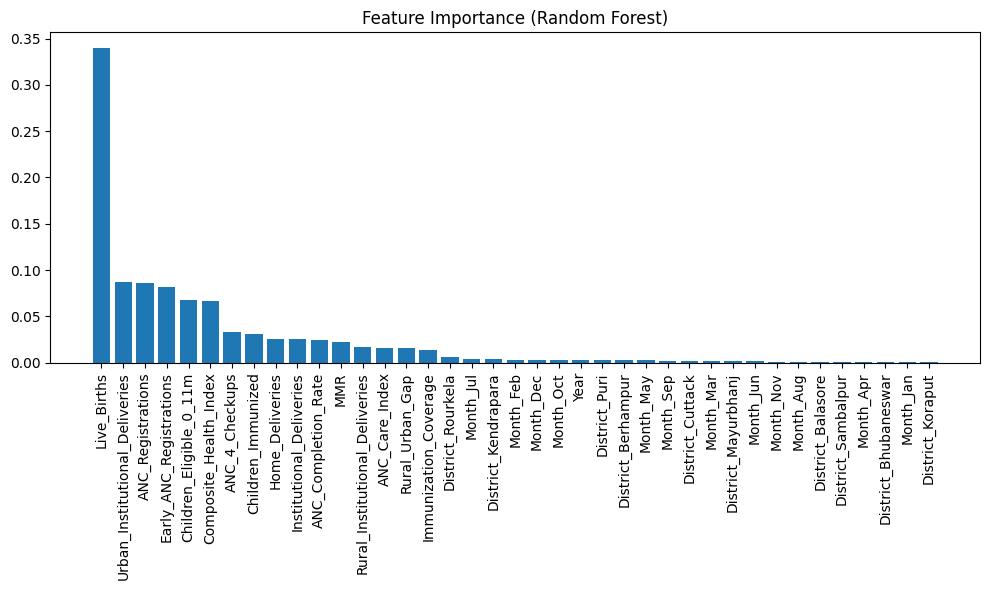

In [25]:
plt.figure(figsize=(10,6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), all_features[indices], rotation=90)
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()

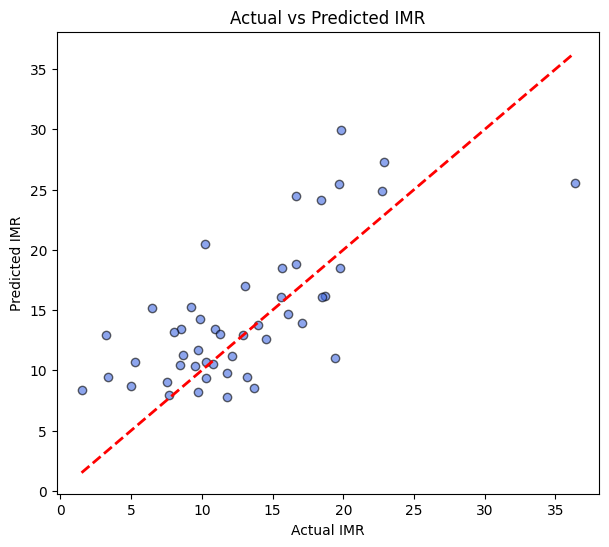

In [27]:
plt.figure(figsize=(7,6))
plt.scatter(y_test, y_pred, alpha=0.6, color="royalblue", edgecolor="k")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # perfect line
plt.xlabel("Actual IMR")
plt.ylabel("Predicted IMR")
plt.title("Actual vs Predicted IMR")
plt.show()

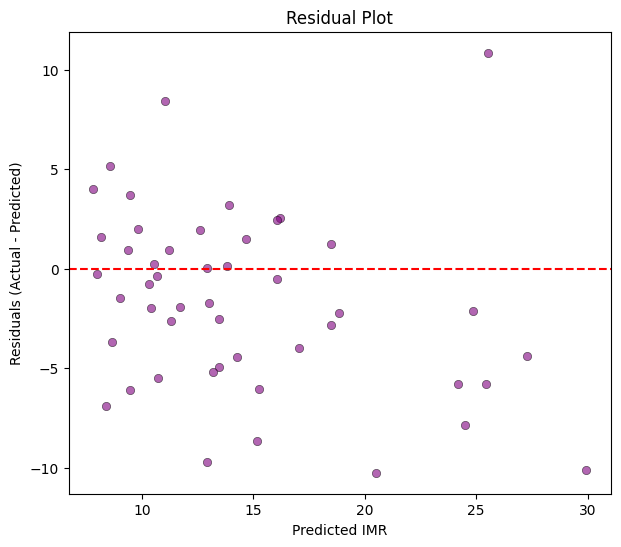

In [28]:
# 2. Residual plot (errors)
residuals = y_test - y_pred
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, color="purple", edgecolor="k")
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted IMR")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()

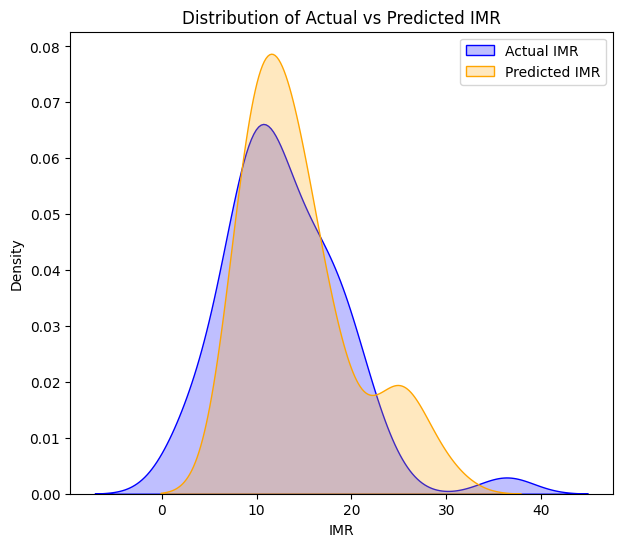

In [29]:
# 3. Distribution comparison
plt.figure(figsize=(7,6))
sns.kdeplot(y_test, label="Actual IMR", fill=True, color="blue")
sns.kdeplot(y_pred, label="Predicted IMR", fill=True, color="orange")
plt.legend()
plt.title("Distribution of Actual vs Predicted IMR")
plt.show()